### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from itertools import product
from tqdm import tqdm
from scipy.special import erf
import scipy.stats

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.core.modeling_framework import MultiCompartmentSphericalMeanModel
from dmipy.signal_models import sphere_models, cylinder_models, gaussian_models

from scipy.io import savemat

/Users/admin/opt/anaconda3/envs/project/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Simulate Signal

In [2]:
def sim_sig_np(bf,be,tm,adc,sigma,axr,nvox):
    
    be_tiled = np.tile(be,(nvox,1))
    bf_tiled = np.tile(bf,(nvox,1))
    tm_tiled = np.tile(tm,(nvox,1))

    adc_tiled = np.transpose(np.tile(adc,(np.size(tm),1)))
    sigma_tiled = np.transpose(np.tile(sigma,(np.size(tm),1)))
    axr_tiled = np.transpose(np.tile(axr,(np.size(tm),1)))

    tm_tiled[(tm_tiled == np.min(tm_tiled)) & (bf_tiled == 0)] = np.inf

    adc_prime_tiled = adc_tiled * (1 - sigma_tiled* np.exp(-tm_tiled*axr_tiled))
    normalised_signal_tiled = np.exp(-adc_prime_tiled * be_tiled)

    return normalised_signal_tiled, adc_prime_tiled

def sim_sig_np_1_vox(bf,be,tm,adc,sigma,axr):

    adc_tiled = np.transpose(np.tile(adc,(np.size(tm),1)))
    sigma_tiled = np.transpose(np.tile(sigma,(np.size(tm),1)))
    axr_tiled = np.transpose(np.tile(axr,(np.size(tm),1)))

    tm[(tm == np.min(tm)) & (bf == 0)] = np.inf

    adc_prime = adc_tiled * (1 - sigma_tiled* np.exp(-tm*axr_tiled))
    normalised_signal = np.exp(-adc_prime * be)
    
    return normalised_signal, adc_prime

def sim_sig_pytorch_new(bf,be,tm,adc,sigma,axr,nvox):
    
    be_tiled = torch.tile(be,(nvox,1))
    bf_tiled = torch.tile(bf,(nvox,1))
    tm_tiled = torch.tile(tm,(nvox,1))

    
    """adc_tiled = torch.tile(adc,(tm.shape[0],1)).t()
    sigma_tiled = torch.tile(sigma,(tm.shape[0],1)).t()
    axr_tiled = torch.tile(axr,(tm.shape[0],1)).t()"""

    adc_tiled = torch.tile(adc,(1,tm.shape[0]))
    sigma_tiled = torch.tile(sigma,(1,tm.shape[0]))
    axr_tiled = torch.tile(axr,(1,tm.shape[0]))

    tm_tiled[(tm_tiled == torch.min(tm_tiled)) & (bf_tiled == 0)] = torch.inf

    """print("be: ", be_tiled.shape)
    print("bf: ", bf_tiled.shape)
    print("tm: ", tm_tiled.shape)
    print("adc: ", adc_tiled.shape)
    print("sigma: ", sigma_tiled.shape)
    print("axr: ", axr_tiled.shape)"""


    adc_prime_tiled = adc_tiled * (1 - sigma_tiled*torch.exp(-tm_tiled*axr_tiled))
    normalised_signal_tiled = torch.exp(-adc_prime_tiled * be_tiled)
    
    return normalised_signal_tiled, adc_prime_tiled

### Initial variables.

In [4]:
nvox = 1000 # number of voxels to simulate

bf = np.array([0, 0, 250, 250, 250, 250, 250, 250]) * 1e-3   # filter b-values [ms/um2]
be = np.array([0, 250, 0, 250, 0, 250, 0, 250]) * 1e-3       # encoding b-values [ms/um2]
tm = np.array([20, 20, 20, 20, 200, 200, 400, 400], dtype=np.float32) * 1e-3 # mixing time [s]

adc_lb = 0.1        #[um2/ms]
adc_ub = 3.5        #[um2/ms]
sig_lb = 0          #[a.u.]
sig_ub = 1          #[a.u.]
axr_lb = 0.1        #[s-1]
axr_ub = 20         #[s-1]

#consider doing in si units

limits = np.array([[adc_lb, adc_ub], [sig_lb, sig_ub] , [axr_lb, axr_ub]])

adc_init = (adc_lb + adc_ub) / 2 #[um2/ms]
sig_init = (sig_lb + sig_ub) / 2 #[a.u.]
axr_init = (axr_lb + axr_ub) / 2 #[ms-1]

num_inits = 5

# Create equally spaced arrays for each parameter
# remove first and last values which are on the "face of the cube"
adc_inits = np.linspace(adc_lb, adc_ub, num_inits)[1:-1]
sig_inits = np.linspace(sig_lb, sig_ub, num_inits)[1:-1]
axr_inits = np.linspace(axr_lb, axr_ub, num_inits)[1:-1]

# Generate all permutations of combinations
all_inits = list(product(adc_inits, sig_inits, axr_inits))

# Convert the list of tuples to a NumPy array
all_inits = np.array(all_inits)

sim_adc = np.random.uniform(adc_lb,adc_ub,nvox)                 # ADC, simulated [um2/ms]
sim_sigma = np.random.uniform(sig_lb,sig_ub,nvox)               # sigma, simulated [a.u.]
sim_axr = np.random.uniform(axr_lb,axr_ub,nvox)                 # AXR, simulated [s-1]

sim_E_vox, sim_adc_prime = sim_sig_np(bf,be,tm,sim_adc,sim_sigma,sim_axr,nvox)


#a_test1,a_test2 = sim_sig_pytorch(bf,be,tm,sim_adc,sim_sigma,sim_axr,len(sim_axr))


### Histogram plots

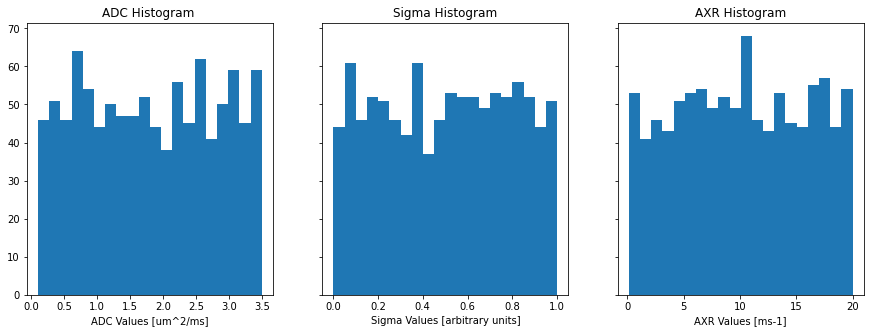

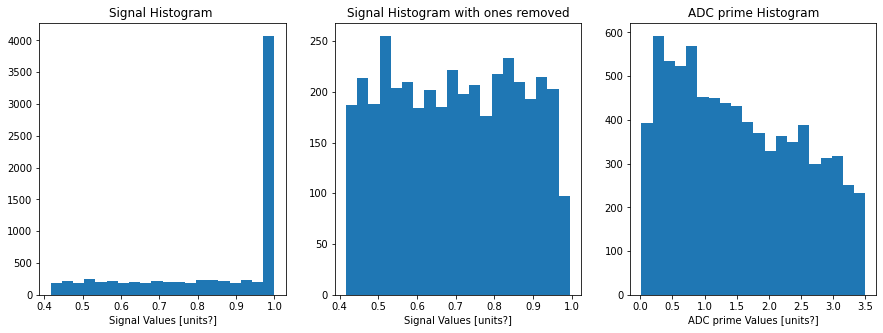

In [5]:
n_bins=20
#make 200 and voxels 100,000 to see adc prime dropoff
fig, axs = plt.subplots(1, 3, sharey=True,figsize=(15, 5))
axs[0].hist(sim_adc, bins=n_bins)
axs[1].hist(sim_sigma, bins=n_bins)
axs[2].hist(sim_axr, bins=n_bins)
axs[0].set_title('ADC Histogram ')
axs[0].set_xlabel('ADC Values [um^2/ms]')
axs[1].set_title('Sigma Histogram')
axs[1].set_xlabel('Sigma Values [arbitrary units]')
axs[2].set_title('AXR Histogram')
axs[2].set_xlabel('AXR Values [ms-1]');


fig, axs = plt.subplots(1, 3,figsize=(15, 5))
axs[0].hist(sim_E_vox.flatten(), bins=n_bins)
axs[0].set_title('Signal Histogram ')
axs[0].set_xlabel('Signal Values [units?]')
axs[1].hist(sim_E_vox[sim_E_vox != 1].flatten(), bins=n_bins)
axs[1].set_title('Signal Histogram with ones removed')
axs[1].set_xlabel('Signal Values [units?]')
axs[2].hist(sim_adc_prime.flatten(), bins=n_bins)
axs[2].set_title('ADC prime Histogram')
axs[2].set_xlabel('ADC prime Values [units?]');


### Plotting b-value against normalised signal

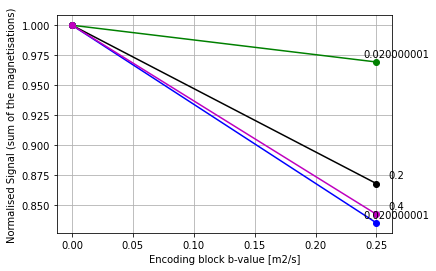

In [6]:
plt.plot([be[0], be[1]], [sim_E_vox[0,0], sim_E_vox[0,1]], 'bo-')
plt.annotate(tm[0], (be[1], sim_E_vox[0, 1]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[2], be[3]], [sim_E_vox[0,2], sim_E_vox[0,3]], 'go-')
plt.annotate(tm[2], (be[3], sim_E_vox[0, 3]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[4], be[5]], [sim_E_vox[0,4], sim_E_vox[0,5]], 'ko-')
plt.annotate(tm[4], (be[5], sim_E_vox[0, 5]), textcoords="offset points", xytext=(20,5), ha='center')

plt.plot([be[6], be[7]], [sim_E_vox[0,6], sim_E_vox[0,7]], 'mo-')
plt.annotate(tm[6], (be[7], sim_E_vox[0, 7]), textcoords="offset points", xytext=(20,5), ha='center')


#plt.title('Scatter plot with 4 lines')
plt.xlabel('Encoding block b-value [m2/s]')
#are units correct
plt.ylabel('Normalised Signal (sum of the magnetisations)')
#unit?
plt.grid(True)
plt.show()


### Least squares fit


In [7]:
def sse_adc_prime_1_vox(variables_to_optimize, tm, bf, be, smeas):
    # For the signal from 1 voxel.
    adc_est, sigma_est, axr_est = variables_to_optimize
    _ , adc_tm_fit = sim_sig_np_1_vox(bf,be,tm,adc_est,sigma_est,axr_est)

    bf_tm = np.column_stack((bf.flatten(), tm.flatten()))

    # Find unique rows and corresponding indices
    univols, univols_indices = np.unique(bf_tm, axis=0, return_index=True)

    nsf = univols.shape[0]

    ix1 = np.where((np.sum(univols[:, None, :] == bf_tm, axis=2) == 2) & (be == 0))[1]
    ix2 = np.where((np.sum(univols[:, None, :] == bf_tm, axis=2) == 2) & (be > 0))[1]
    
    #this line is hardcoded
    smeas = smeas.reshape(8)

    adc_tm_calc = -1 / (be[ix2] - be[ix1]) * np.log(smeas[ix2] / smeas[ix1])

    #this line is hardcoded
    adc_tm_fit = adc_tm_fit[:, ::2]

    sse = np.sum((adc_tm_calc - adc_tm_fit) ** 2)
    return sse


In [8]:
def callback(xk):
    print('Estimates of ADC, sigma, AXR:    ', xk)

# Define the bounds for adc, sigma, axr
bounds = tuple(map(tuple, limits.tolist())) #this line seems messy

NLLS_adc_all = np.empty(shape=(0,))
NLLS_sigma_all = np.empty(shape=(0,))
NLLS_axr_all = np.empty(shape=(0,))
    
NLLS_adc_prime_all = np.empty(shape=(nvox,8))
NLLS_E_vox_all = np.empty(shape= (nvox,8))

sses = np.array([])
for current_vox in range(nvox):
    #reset best for each voxel
    best_sse = 1

    #extract relevant info for current voxel
    cur_E_vox = sim_E_vox[current_vox,:]
    cur_adc_prime = sim_adc_prime[current_vox,:]

    cur_adc = sim_adc[current_vox]
    cur_sigma = sim_sigma[current_vox]
    cur_axr = sim_axr[current_vox]

    additional_args_1_vox = (tm, bf, be, cur_E_vox) 

    for combination in range(all_inits.shape[0]):
        inits = all_inits[combination,:]
        
        result_1_vox = scipy.optimize.minimize(sse_adc_prime_1_vox, inits, args=additional_args_1_vox, bounds=bounds)

        if result_1_vox.fun < best_sse:
            best_sse = result_1_vox.fun
            NLLS_cur_adc, NLLS_cur_sigma, NLLS_cur_axr = result_1_vox.x
    
    sses = np.append(sses,best_sse)
    # note the 1 instead of nvox, because it is for 1 voxel 
    NLLS_cur_E_vox, NLLS_cur_adc_prime = sim_sig_np_1_vox(bf,be,tm,NLLS_cur_adc, NLLS_cur_sigma, NLLS_cur_axr)

    NLLS_adc_all = np.append(NLLS_adc_all, NLLS_cur_adc)
    NLLS_sigma_all = np.append(NLLS_sigma_all, NLLS_cur_sigma)
    NLLS_axr_all = np.append(NLLS_axr_all, NLLS_cur_axr)
    
    NLLS_adc_prime_all[current_vox,:] = NLLS_cur_adc_prime
    NLLS_E_vox_all[current_vox,:] = NLLS_cur_E_vox

KeyboardInterrupt: 

### NLLS Plots

In [ ]:
#Debugging sse and seeing how large it is for the worst values. 
sses.sort()
sses_descending = sses[::-1]


"""MAYBE ADD LOSS PER 'EPOCH' FOR NLLS
plt.figure()
plt.plot(range(1, len(loss_progress) + 1), loss_progress, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.show()"""


#plotting the sse
plt.figure()
plt.hist(sses.flatten(), bins=200)

plt.figure()
# for first voxel
plt.scatter(be, sim_E_vox[0,:], label='simulated')
plt.scatter(be, NLLS_E_vox_all[0,:], label='predicted')
plt.xlabel("be")
plt.ylabel("tm")
plt.legend()

# plot scatter plots to analyse correlation of predicted free params against ground truth
plt.figure()

param_sim = [sim_adc, sim_sigma, sim_axr]
param_pred = [NLLS_adc_all, NLLS_sigma_all, NLLS_axr_all]
param_name = ['ADC', 'Sigma', 'AXR']

rvals = []

for i,_ in enumerate(param_sim):
    plt.rcParams['font.size'] = '16'
    plt.scatter(param_sim[i], param_pred[i], s=2, c='navy')
    plt.xlabel(param_name[i] + ' Ground Truth')
    plt.ylabel(param_name[i] + ' Prediction')
    #check what line below does. Commented out because it gave an error when using 1 voxel
    #rvals.append(scipy.stats.pearsonr(np.squeeze(param_sim[i]), np.squeeze(param_pred[i])))
    plt.tight_layout
    plt.show()

print(rvals)


### Creating the neural network

In [13]:
class Net(nn.Module): # this is the neural network
    #defining the init and foward pass functions. 

    def __init__(self,be,bf,tm,nparams,limits):
        super(Net, self).__init__()

        self.be = be
        self.bf = bf
        self.tm = tm
        self.limits = limits

        #defining the layers that we want. 
        # 3 layers with no. of be nodes. 
        self.layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.layers.extend([nn.Linear(len(be), len(be)), nn.PReLU()])
            #https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html
        self.encoder = nn.Sequential(*self.layers, nn.Linear(len(be), nparams))

    def forward(self, E_vox):

        params = torch.nn.functional.softplus(self.encoder(E_vox))
        #running a forward pass through the network

        #SoftPlus is a smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive
        #params contains batch_size x nparams outputs, so each row is adc, sigma and axr.

        #unsqueeze adds an additional dimension. 
        #parameter constraints from Elizabeth matlab 

        adc = torch.clamp(params[:, 0].unsqueeze(1), min=limits[0,0], max=limits[0,1])
        sigma = torch.clamp(params[:, 1].unsqueeze(1), min=limits[1,0], max=limits[1,1])
        axr = torch.clamp(params[:, 2].unsqueeze(1), min=limits[2,0], max=limits[2,1])
        
        self.tm[(self.tm == torch.min(self.tm)) & (self.bf == 0)] = float('inf')

        adc_prime = adc * (1 - sigma * torch.exp(-tm * axr))
        E_vox = torch.exp(-adc_prime * be)

        print("tm:", self.tm.shape)
        print("be:", self.be.shape)
        print("bf:", self.bf.shape)
        print("adc:", adc.shape)
        print("sigma:", sigma.shape)
        print("axr:", axr.shape)
        print("evox:", E_vox.shape)

        return E_vox, adc_prime, adc, sigma, axr


### NN continued

In [14]:
# define network
nparams = 3
#because of adc, sigma and axr

#converting numpy arrays to pytorch tensors. 
#be = torch.tensor(be)
#bf = torch.tensor(bf)
#tm = torch.tensor(tm)
be = torch.tensor(be, dtype=torch.float32)
bf = torch.tensor(bf, dtype=torch.float32)
tm = torch.tensor(tm, dtype=torch.float32)

batch_size = 128

#initilise network
net = Net(be, bf, tm, nparams,limits)

#create batch queues for data
#// means divide and round down. 
num_batches = len(sim_E_vox) // batch_size

#import the sim_E_vox array into the dataloader
#drop_last ignores the last batch if it is the wrong size. 
#num_workers is about performance. 

trainloader = utils.DataLoader(torch.from_numpy(sim_E_vox.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 0, #was 2 previously
                                drop_last = True)

# loss function and optimizer
#choosing which loss function to use. 
#not sure what the optmizer is
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

# best loss
best = 1e16
num_bad_epochs = 0
#can increase patience a lot, speed not an issue.
patience = 10

/Users/admin/opt/anaconda3/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == "__main__":
/Users/admin/opt/anaconda3/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/Users/admin/opt/anaconda3/envs/project/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.in

### Training

In [15]:
# train
loss_progress = np.empty(shape=(0,)) 
num_bad_epochs = 0

for epoch in range(10000): 
    print("-----------------------------------------------------------------")
    print("epoch: {}; bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    #tqdm shows a progress bar. 
    for i, sim_E_vox_batch in enumerate(tqdm(trainloader), 0):
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred_E_vox, pred_adc_prime, pred_adc, pred_sigma, pred_axr = net(sim_E_vox_batch)
        
        """print(pred_E_vox)
        print(pred_adc)
        print(pred_sigma)
        print(pred_axr)"""

        """if torch.isnan(pred_E_vox).any():
            print("evox nan found")
        if torch.isnan(pred_adc).any():
            print("pred_adc nan found")
        if torch.isnan(pred_axr).any():
            print("pred_axr nan found")
        if torch.isnan(pred_sigma).any():
            print("sigpred_sigma nan found")"""
            
        #sim_E_vox_batch32 = sim_E_vox_batch.to(torch.float32)
        #needed so that loss comparison works
        
        #print(pred_E_vox)
        loss_sig = criterion(pred_E_vox, sim_E_vox_batch)
        #loss_prime = criterion(pred_adc_prime,sim_adc_prime)
        #loss prime needs sim_adc_prime to be batched. 

        loss_sig.backward()
        optimizer.step()
        running_loss += loss_sig.item()
        
    print("loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("####################### saving good model #######################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
        loss_progress = np.append(loss_progress, best)
    else:
        num_bad_epochs = num_bad_epochs + 1
        loss_progress = np.append(loss_progress, best)
        if num_bad_epochs == patience:
            print("done, best loss: {}".format(best))
            break
print("done")

net.load_state_dict(final_model)

net.eval()
with torch.no_grad():
    final_pred_E_vox, final_pred_adc_repeated, final_pred_sigma_repeated, final_pred_axr_repeated = net(torch.from_numpy(sim_E_vox.astype(np.float32)))
    # adc sigma and axr will have 8 columns which are all the same

final_pred_adc = final_pred_adc_repeated[:, 0]
final_pred_sigma = final_pred_sigma_repeated [:, 0]
final_pred_axr = final_pred_axr_repeated[:, 0]


-----------------------------------------------------------------
epoch: 0; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 312.07it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 183.16it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 235.90it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 277.94it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 181.56it/s]


loss: 0.2427457831799984
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 5; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 224.69it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.24320735596120358
-----------------------------------------------------------------
epoch: 6; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 193.71it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


loss: 0.24904804304242134
-----------------------------------------------------------------
epoch: 7; bad epochs: 2


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 137.00it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.24241390824317932
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 8; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 206.81it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 172.54it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 115.65it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


loss: 0.24345892295241356
-----------------------------------------------------------------
epoch: 11; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 195.68it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 267.49it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 177.24it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.23923814110457897
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 14; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 155.59it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.24102390557527542
-----------------------------------------------------------------
epoch: 15; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 149.76it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

loss: 0.23616039752960205
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 16; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 129.53it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.2412948850542307
-----------------------------------------------------------------
epoch: 17; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 138.55it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.23984801769256592
-----------------------------------------------------------------
epoch: 18; bad epochs: 2


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 157.21it/s]


loss: 0.23302719928324223
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 19; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 208.18it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 226.47it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 161.27it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 86.91it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.2391822226345539
-----------------------------------------------------------------
epoch: 23; bad epochs: 4


100%|██████████| 7/7 [00:00<00:00, 168.56it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 190.88it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 147.77it/s]


loss: 0.2381532322615385
-----------------------------------------------------------------
epoch: 26; bad epochs: 2


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 142.80it/s]


loss: 0.2341939676553011
-----------------------------------------------------------------
epoch: 27; bad epochs: 3


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 170.02it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.23446686007082462
-----------------------------------------------------------------
epoch: 28; bad epochs: 4


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 107.55it/s]


loss: 0.23189296200871468
-----------------------------------------------------------------
epoch: 29; bad epochs: 5


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 209.10it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 193.55it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

-----------------------------------------------------------------
epoch: 31; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 161.82it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


loss: 0.2346727680414915
-----------------------------------------------------------------
epoch: 32; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 156.55it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


loss: 0.22833631373941898
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 33; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 83.74it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 194.59it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 185.91it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.2240945640951395
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 36; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm:

100%|██████████| 7/7 [00:00<00:00, 75.29it/s]


 torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
t

100%|██████████| 7/7 [00:00<00:00, 216.11it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 204.73it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.22935092262923717
-----------------------------------------------------------------
epoch: 39; bad epochs: 1



  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 164.97it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 111.38it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.22875269502401352
-----------------------------------------------------------------
epoch: 41; bad epochs: 3


  0%|          | 0/7 [00:00<?, ?it/s]

tm:

100%|██████████| 7/7 [00:00<00:00, 143.23it/s]


 torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
t

100%|██████████| 7/7 [00:00<00:00, 177.91it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 284.21it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 116.65it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.2251326646655798
-----------------------------------------------------------------
epoch: 45; bad epochs: 7


100%|██████████| 7/7 [00:00<00:00, 208.46it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 316.00it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 227.93it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.22057477943599224
-----------------------------------------------------------------
epoch: 48; bad epochs: 2


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 271.92it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

loss: 0.22240941412746906
-----------------------------------------------------------------
epoch: 49; bad epochs: 3


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 175.28it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.21906586177647114
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 50; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 223.27it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.22437178529798985
-----------------------------------------------------------------
epoch: 51; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 284.33it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.2245624866336584
-----------------------------------------------------------------
epoch: 52; bad epochs: 2


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 191.72it/s]


loss: 0.2217557579278946
-----------------------------------------------------------------
epoch: 53; bad epochs: 3


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 140.06it/s]


loss: 0.21964112296700478
-----------------------------------------------------------------
epoch: 54; bad epochs: 4


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 114.30it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.22114567644894123
-----------------------------------------------------------------
epoch: 55; bad epochs: 5



  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 198.06it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.2150581106543541
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 5


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 198.19it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


loss: 0.21885939314961433
-----------------------------------------------------------------
epoch: 57; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 126.40it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.2150417435914278
####################### saving good model #######################


-----------------------------------------------------------------
epoch: 58; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: 

 86%|████████▌ | 6/7 [00:00<00:00, 38.80it/s]

torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 40.53it/s]


loss: 0.21713802963495255
-----------------------------------------------------------------
epoch: 59; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 208.53it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.22053910046815872
-----------------------------------------------------------------
epoch: 60; bad epochs: 2


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 274.78it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.21382173523306847
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 61; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 206.05it/s]


loss: 0.2167005818337202
-----------------------------------------------------------------
epoch: 62; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 200.70it/s]


loss: 0.21535924822092056
-----------------------------------------------------------------
epoch: 63; bad epochs: 2


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 169.70it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.21772555075585842
-----------------------------------------------------------------
epoch: 64; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 261.51it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 199.11it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.20932437293231487
-----------------------------------------------------------------
epoch: 66; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 278.53it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 145.17it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.21423622407019138
-----------------------------------------------------------------
epoch: 68; bad epochs: 3


100%|██████████| 7/7 [00:00<00:00, 218.03it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 126.59it/s]


loss: 0.20884756743907928
-----------------------------------------------------------------
epoch: 70; bad epochs: 5


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 182.67it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.20547906681895256
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 71; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 218.59it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 129.29it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.20646615512669086
-----------------------------------------------------------------
epoch: 73; bad epochs: 2


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm:

100%|██████████| 7/7 [00:00<00:00, 103.04it/s]

 torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.2045756634324789
####################### saving good model #######################


-----------------------------------------------------------------
epoch: 74; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 202.94it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


 57%|█████▋    | 4/7 [00:00<00:00, 33.97it/s]

tm:

100%|██████████| 7/7 [00:00<00:00, 46.66it/s]


 torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.2021828480064869
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 76; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 214.90it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


loss: 0.19772417098283768
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 77; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 273.78it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 221.49it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.19663101807236671
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 79; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 173.73it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.20058966428041458
-----------------------------------------------------------------
epoch: 80; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 169.14it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.1993854120373726
-----------------------------------------------------------------
epoch: 81; bad epochs: 2


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 128.75it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.19745806977152824
-----------------------------------------------------------------
epoch: 82; bad epochs: 3


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 160.75it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.1946151815354824
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 83; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 210.03it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


loss: 0.1924498714506626
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 84; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 226.49it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.1923817154020071
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 85; bad epochs: 0



  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 172.17it/s]


loss: 0.19060875475406647
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 86; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 84.93it/s]


loss: 0.18799930438399315
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 87; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 144.44it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.18643362633883953
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 88; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 144.39it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.18510746397078037
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 89; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 156.34it/s]


loss: 0.18431385606527328
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 90; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 273.89it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 135.36it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.18542291410267353
-----------------------------------------------------------------
epoch: 92; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 199.04it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 173.75it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.17894543893635273
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 94; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 94.80it/s]


loss: 0.180045111104846
-----------------------------------------------------------------
epoch: 95; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 172.18it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.17604983039200306
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 96; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 119.89it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.1724836453795433
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 97; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 242.37it/s]


loss: 0.1738244779407978
-----------------------------------------------------------------
epoch: 98; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm:

100%|██████████| 7/7 [00:00<00:00, 191.82it/s]

 torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
t

loss: 0.17006484419107437
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 99; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 127.92it/s]


loss: 0.1683317180722952
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 100; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 193.65it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.16763512045145035
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 101; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 87.57it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.16196615248918533
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 102; bad epochs: 0



  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 190.69it/s]


loss: 0.16113562136888504
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 103; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 131.01it/s]

loss: 0.16112283617258072


####################### saving good model #######################
-----------------------------------------------------------------
epoch: 104; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 209.69it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 241.07it/s]

loss: 0.1582666728645563


-----------------------------------------------------------------
epoch: 106; bad epochs: 1


100%|██████████| 7/7 [00:00<00:00, 259.53it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 278.66it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.1505922805517912
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 108; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 242.65it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 197.69it/s]


loss: 0.14535153284668922
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 110; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 244.64it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

loss: 0.14394779689610004
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 111; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 220.03it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]


####################### saving good model #######################
-----------------------------------------------------------------
epoch: 112; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 222.33it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

loss: 0.1434087809175253
-----------------------------------------------------------------
epoch: 113; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 147.87it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.13746318593621254
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 114; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 159.83it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.1376110017299652
-----------------------------------------------------------------
epoch: 115; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 169.62it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.13431652821600437
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 116; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 184.79it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.13168069534003735


####################### saving good model #######################
-----------------------------------------------------------------
epoch: 117; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 130.74it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.13326626643538475
-----------------------------------------------------------------
epoch: 118; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 182.83it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.13028156384825706
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 189.79it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.12645519897341728
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 120; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 157.29it/s]


loss: 0.12741960771381855
-----------------------------------------------------------------
epoch: 121; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 123.63it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.1233171634376049
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 122; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 104.83it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.12233409285545349
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 123; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 189.87it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.11864382773637772
####################### saving good model #######################


-----------------------------------------------------------------
epoch: 124; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 152.71it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.11828693561255932
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 125; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 208.68it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.11596104502677917
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 126; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 160.23it/s]


loss: 0.1156211793422699
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 127; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 152.73it/s]


loss: 0.11387626267969608
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 128; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 139.50it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.11039676051586866
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 186.37it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.10907011106610298
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 130; bad epochs: 0


100%|██████████| 7/7 [00:00<00:00, 249.35it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 167.62it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.10837824828922749
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 132; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 111.26it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.10837143938988447
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 133; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 258.88it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.10640985425561666
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 134; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 158.62it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


loss: 0.10501714888960123
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 135; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 190.01it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.10372551716864109
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 136; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 301.38it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.10291663371026516
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 137; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 184.12it/s]


loss: 0.10270589124411345
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 138; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 273.61it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.10123543161898851
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 139; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 93.08it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


loss: 0.10138163808733225
-----------------------------------------------------------------
epoch: 140; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 98.82it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.10044345073401928
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 141; bad epochs: 0



  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 191.45it/s]


loss: 0.10105414781719446
-----------------------------------------------------------------
epoch: 142; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 128.27it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09877037070691586
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 143; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 180.23it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


loss: 0.1007365919649601
-----------------------------------------------------------------
epoch: 144; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 161.42it/s]


loss: 0.09858859051018953
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 145; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 161.25it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09936832357198
-----------------------------------------------------------------
epoch: 146; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 165.21it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


loss: 0.09905572421848774
-----------------------------------------------------------------
epoch: 147; bad epochs: 2


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 154.78it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09901111479848623
-----------------------------------------------------------------
epoch: 148; bad epochs: 3


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 194.47it/s]


loss: 0.10013781115412712
-----------------------------------------------------------------
epoch: 149; bad epochs: 4


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 131.82it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


loss: 0.09812136646360159
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 150; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 169.96it/s]


loss: 0.09763763379305601
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 151; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 129.97it/s]


loss: 0.0972718233242631
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 152; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 130.57it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09771815966814756
-----------------------------------------------------------------
epoch: 153; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 151.00it/s]


loss: 0.09930413123220205
-----------------------------------------------------------------
epoch: 154; bad epochs: 2


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 144.73it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09785861242562532
-----------------------------------------------------------------
epoch: 155; bad epochs: 3


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 150.72it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09682818409055471
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 156; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm:

100%|██████████| 7/7 [00:00<00:00, 183.87it/s]


 torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09669617097824812
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 157; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


 14%|█▍        | 1/7 [00:00<00:00,  7.50it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 38.35it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09860657621175051
-----------------------------------------------------------------
epoch: 158; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 121.40it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09779451135545969
-----------------------------------------------------------------
epoch: 159; bad epochs: 2


100%|██████████| 7/7 [00:00<00:00, 188.38it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 174.94it/s]


loss: 0.09717996139079332
-----------------------------------------------------------------
epoch: 161; bad epochs: 4


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 101.35it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 209.99it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09656845312565565
-----------------------------------------------------------------
epoch: 163; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 172.50it/s]


loss: 0.09510612860321999
####################### saving good model #######################
-----------------------------------------------------------------
epoch: 164; bad epochs: 0


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 207.41it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.0966127049177885
-----------------------------------------------------------------
epoch: 165; bad epochs: 1


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 207.86it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09756898786872625
-----------------------------------------------------------------
epoch: 166; bad epochs: 2


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 236.91it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.0973495664075017
-----------------------------------------------------------------
epoch: 167; bad epochs: 3


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 159.63it/s]


loss: 0.09674167726188898
-----------------------------------------------------------------
epoch: 168; bad epochs: 4


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 208.41it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.0959434425458312
-----------------------------------------------------------------
epoch: 169; bad epochs: 5



100%|██████████| 7/7 [00:00<00:00, 171.22it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 198.38it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09554073493927717
-----------------------------------------------------------------
epoch: 171; bad epochs: 7


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 173.84it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09800853114575148
-----------------------------------------------------------------
epoch: 172; bad epochs: 8


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])


100%|██████████| 7/7 [00:00<00:00, 185.42it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09818932134658098
-----------------------------------------------------------------
epoch: 173; bad epochs: 9


  0%|          | 0/7 [00:00<?, ?it/s]

tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8]

100%|██████████| 7/7 [00:00<00:00, 148.52it/s]


tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([128, 1])
sigma: torch.Size([128, 1])
axr: torch.Size([128, 1])
evox: torch.Size([128, 8])
loss: 0.09732298273593187
done, best loss: 0.09510612860321999
done
tm: torch.Size([8])
be: torch.Size([8])
bf: torch.Size([8])
adc: torch.Size([1000, 1])
sigma: torch.Size([1000, 1])
axr: torch.Size([1000, 1])
evox: torch.Size([1000, 8])


ValueError: too many values to unpack (expected 4)

### NN Plots

In [ ]:
plt.figure()
plt.plot(range(1, len(loss_progress) + 1), loss_progress, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.show()

final_pred_E_vox_detached = final_pred_E_vox.detach().numpy()
"""Was having numpy pytorch issues, so this line helps fix it a bit."""

plt.scatter(be, sim_E_vox[0,:], label='simulated')
plt.scatter(be, final_pred_E_vox_detached[0,:], label='predicted')
plt.legend()

# plot scatter plots to analyse correlation of predicted free params against ground truth
plt.figure()

param_sim = [sim_adc, sim_sigma, sim_axr]
param_pred = [final_pred_adc, final_pred_sigma, final_pred_axr]
param_name = ['ADC', 'Sigma', 'AXR']

rvals = []

for i,_ in enumerate(param_sim):
    plt.rcParams['font.size'] = '16'
    plt.scatter(param_sim[i], param_pred[i], s=2, c='navy')
    plt.xlabel(param_name[i] + ' Ground Truth')
    plt.ylabel(param_name[i] + ' Prediction')
    rvals.append(scipy.stats.pearsonr(np.squeeze(param_sim[i]), np.squeeze(param_pred[i])))
    plt.tight_layout
    plt.show()

print(rvals)
